# Ejercicio 3

El objetivo de este problema es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales de las seis categorías distintas, utilizando el dataset proporcionado.

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:
* buildings
* forest
* glacier
* mountain
* sea
* street
Las imágenes están divididas en tres conjuntos:
* Train: Alrededor de 14,000 imágenes para entrenamiento.
* Test: Alrededor de 3,000 imágenes para evaluación del modelo.
* Prediction: Alrededor de 7,000 imágenes para predicción final.

Los modelos que diseñamos en este ejercicio son:
* Modelo con capas densas.
* Modelo con capas convolucionales y densas.
* Modelo que incluya bloques residuales identidad
* Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning) --> Implementamos MobileNet

## Preparación del entorno.

Si no estamos parados en el repo, clonar y cd al repo. Esto nos permite usar el mismo notebook tanto local como en Google Colab.

In [86]:
import os

REPO_NAME = "TP1-AA2-GarciaValeri"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/LaraV15/TP1-AA2-GarciaValeri.git
  os.chdir(REPO_NAME)

Importar librerías

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling, Concatenate
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Dropout
from tensorflow.keras.layers import ReLU, Add, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet

import matplotlib.pyplot as plt
from PIL import Image
import time
from tensorflow.keras.callbacks import EarlyStopping



Establecer GPU por defecto en caso de estar disponible.

In [88]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Análisis Exploratorio.

Carga de datos

In [89]:
# Directorio de los datos
DATA_DIRECTORY = Path("TP-1-EJ3/seg_train")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

Exploración inicial de las categorías y cantidad de imágenes

buildings: 2191 imágenes


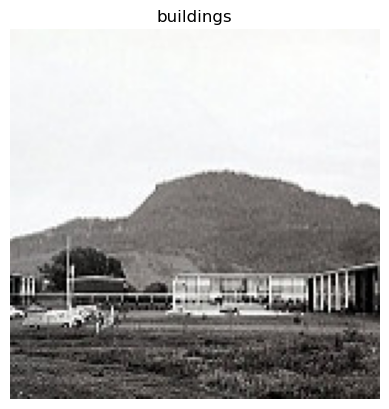

forest: 2271 imágenes


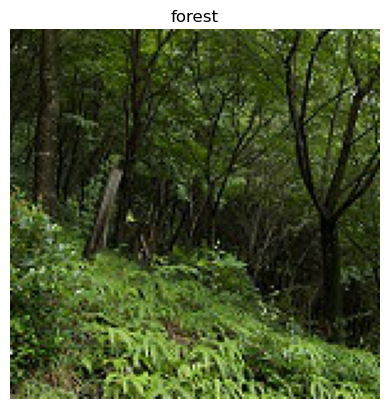

glacier: 2404 imágenes


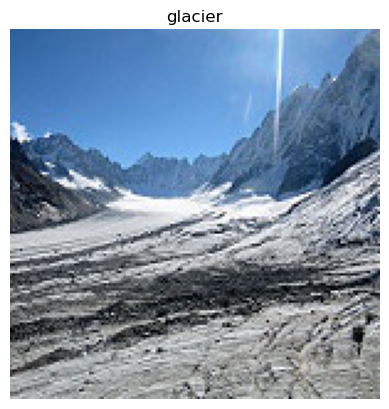

mountain: 2512 imágenes


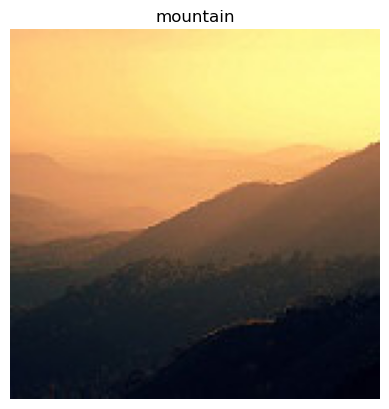

sea: 2274 imágenes


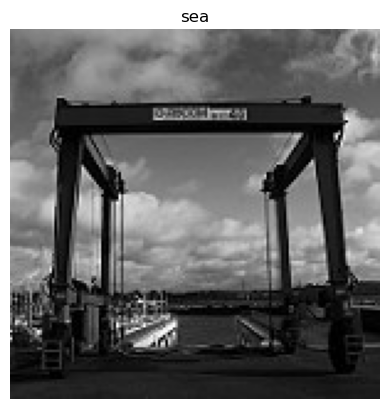

street: 2382 imágenes


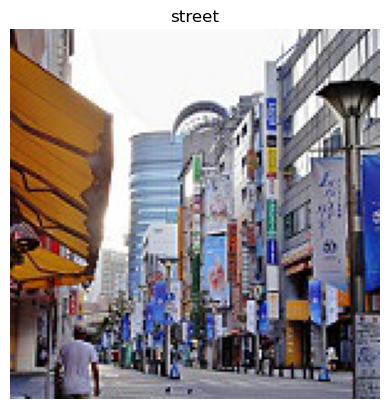

In [90]:
for category in os.listdir(DATA_DIRECTORY):
    category_path = DATA_DIRECTORY / category
    if category_path.is_dir():
        print(f"{category}: {len(os.listdir(category_path))} imágenes")
        
        # Muestra una imagen aleatoria por categoría
        img_path = category_path / os.listdir(category_path)[0]
        img = Image.open(img_path)
        plt.figure()
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
        plt.show()

In [91]:
class_counts = np.array([2191, 2271, 2404, 2512, 2274, 2382])
total_images = class_counts.sum()

# Porcentajes por clase
percentages = (class_counts / total_images) * 100
for i, category in enumerate(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']):
    print(f"{category}: {percentages[i]:.2f}%")

buildings: 15.61%
forest: 16.18%
glacier: 17.13%
mountain: 17.90%
sea: 16.20%
street: 16.97%


A partir de los valores obtenidos podemos concluir que el dataser esta equilibrado y que no es necesario aplicar técnicas adicionales.

In [92]:
# Carga los datos de entrenamiento, validación, test y predicción
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "TP-1-EJ3/seg_test",
    label_mode="categorical",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

pred_ds = tf.keras.utils.image_dataset_from_directory(
    "TP-1-EJ3/seg_pred",
    label_mode=None,  # No hay etiquetas en este conjunto
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files.


In [93]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Visualizar los datos:

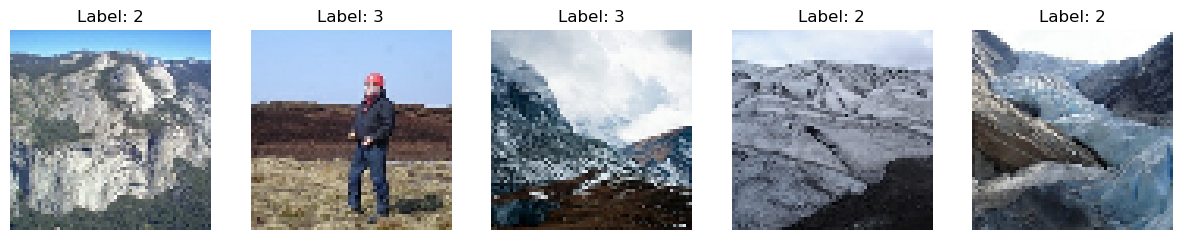

In [94]:
# Visualización de algunas imágenes del dataset de entrenamiento
for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = images[i].numpy()  # Convertir imagen a numpy array
        
        # Asegurar que la imagen esté en el rango [0, 1]
        if img.max() > 1.0:
            img = np.clip(img / 255.0, 0, 1)  # Normalizar si es necesario

        # Mostrar la imagen
        axs[i].imshow(img)
        axs[i].set_title(f"Label: {np.argmax(labels[i])}")
        axs[i].axis('off')

    plt.show()

# Modelo con capas densas

Definimos nuestro modelo usando tensorflow.

In [95]:
model_1 = Sequential([
    Input(shape=(64, 64, 3)),
    Flatten(),
    Rescaling(1./255),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

Entrenamos el modelo.

In [96]:
# Compilar el modelo
model_1.compile(optimizer="adam",
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

# Entrenar el modelo
time_1 = time.time()
history_1 = model_1.fit(
    train_ds,  # Dataset de entrenamiento
    validation_data=val_ds,  # Dataset de validación
    epochs=10,
    shuffle=True
)
time_2 = time.time()

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.3942 - loss: 1.8416 - val_accuracy: 0.4840 - val_loss: 1.3427
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5006 - loss: 1.3305 - val_accuracy: 0.4547 - val_loss: 1.4026
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5262 - loss: 1.2636 - val_accuracy: 0.5110 - val_loss: 1.3072
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5301 - loss: 1.2405 - val_accuracy: 0.4990 - val_loss: 1.3428
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5403 - loss: 1.2240 - val_accuracy: 0.4797 - val_loss: 1.3523
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5429 - loss: 1.2178 - val_accuracy: 0.5223 - val_loss: 1.2899
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5618 - loss: 1.1755 - val_accuracy: 0.5050 - val_loss: 1.3387
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5584 - loss: 1.1723 - val_acc

Plot del historial de métricas.

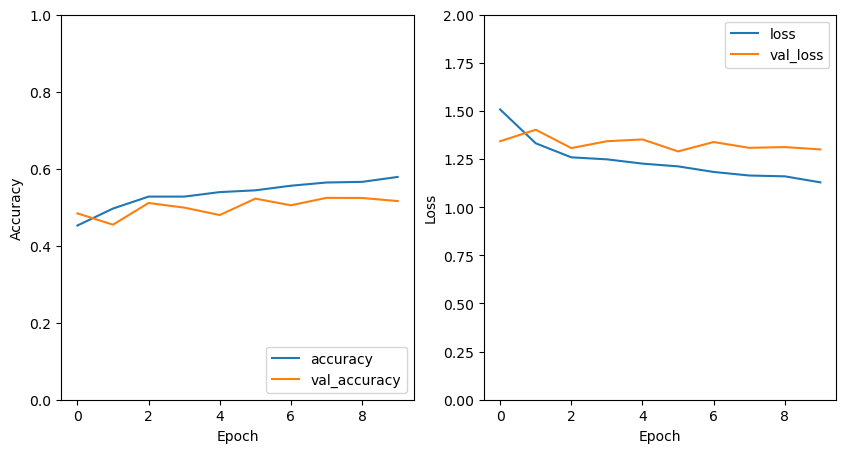

In [97]:
# Plot the training history, accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='loss')
plt.plot(history_1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')


Podemos observar que el accuracy de validación varia entre 46 - 54 %, lo cual nos dice que no es un desempeño muy bueno del modelo. Además podemos concluir que  el modelo no está sobreajustando. Observamos que el rendimiento en entrenamiento mejora progresivamente, mientras que el rendimiento en validación no mejora de forma consistente e incluso empeora hacia las últimas épocas.

Aunque el val_loss baja en algunas épocas intermedias, al final aumenta a 1.37, lo que sugiere que el modelo no generaliza bien en los datos de validación.
Aunque hay una pequeña mejora en la precisión,es baja (alrededor de 0.6). Veremos si con otros modelos lograr mejorar estos resultados.

Probamos predicciones sobre el conjunto de test.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


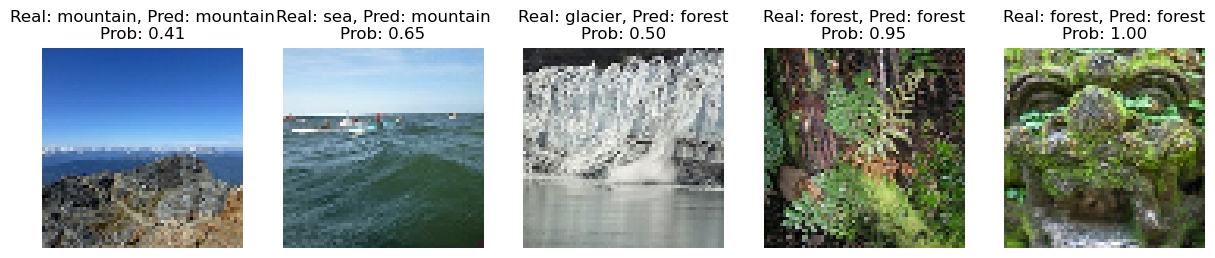

In [98]:
i = 0
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for images, labels in val_ds.take(5):  # Tomamos un batch del conjunto de validación
    Y_pred = model_1.predict(images)

    idx = np.random.randint(0, images.shape[0])  # Selecciona un índice aleatorio del batch
    x_test = images[idx].numpy()  # Imagen de prueba

    # Asegurar que la imagen esté en el rango [0, 1]
    if x_test.max() > 1.0:
        x_test = np.clip(x_test / 255.0, 0, 1)

    y_test_label = np.argmax(labels[idx].numpy())  # Clase real
    y_pred = np.argmax(Y_pred[idx])  # Clase predicha
    y_pred_prob = np.max(Y_pred[idx])  # Probabilidad de la clase predicha

    # Mostrar la imagen
    axs[i].imshow(x_test)  # Mostrar la imagen RGB
    axs[i].axis('off')

    # Mostrar el título con la clase real, la predicha y la probabilidad
    axs[i].set_title(f"Real: {class_names[y_test_label]}, Pred: {class_names[y_pred]}\nProb: {y_pred_prob:.2f}")

    i += 1 

plt.show()


A pesar de que el modelo no tiene un valor alto de precisión, podemos observar que logra predecir correctamente algunas imagenes.

Como las imagenes van cambiando en cada ejecución del codigo, adjuntamos la imagen obtenida al momento de escribir estas conclusiones.

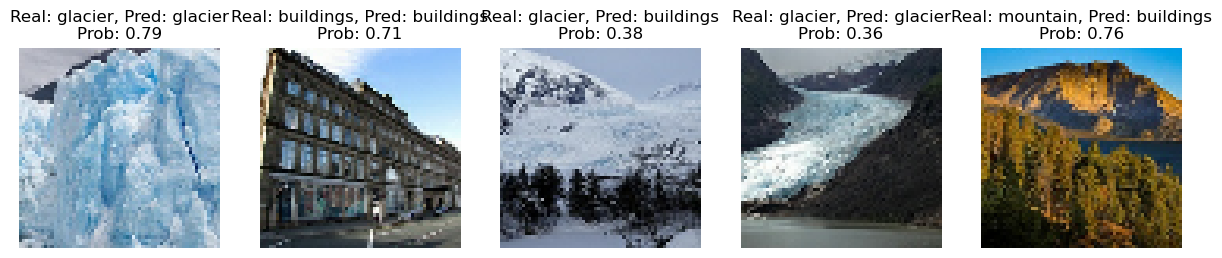

In [99]:
# Guardamos algunas características del modelo para utilizarlas después
results = []

In [100]:
def results_model(inicio_entrenamiento, fin_entrenamiento, nombre_modelo, model, history):
    parametros_totales = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    results.append({
    "Modelo": nombre_modelo,
    "Train Accuracy":  round(history.history['accuracy'][-1], 2),
    "Val Accuracy":  round(history.history['val_accuracy'][-1], 2),
    "Total Parámetros": parametros_totales,
    "Parámetros Entrenables": trainable_params,
    "Parámetros No Entrenables": non_trainable_params,
    "Tiempo Entrenamiento (min)": round((fin_entrenamiento - inicio_entrenamiento)/60, 2)
    })

In [101]:
results_model(time_1, time_2, "Modelo con capas densas", model_1, history_1)
print(results)

[{'Modelo': 'Modelo con capas densas', 'Train Accuracy': 0.58, 'Val Accuracy': 0.52, 'Total Parámetros': 786886, 'Parámetros Entrenables': 786886, 'Parámetros No Entrenables': 0, 'Tiempo Entrenamiento (min)': 1.24}]


# Modelo con capas convolucionales y densas.

In [102]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [103]:
print("Building model")
model_2 = build_model((64, 64, 3), num_classes)

model_2.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [104]:
model_2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 64, 64, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 62, 62, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 60, 60, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │        13,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,358 (149.84 KB)

 Trainable params: 38,358 (149.84 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Entrena el modelo
time_3 = time.time()
history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=True
)
time_4 = time.time()

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.3849 - loss: 1.4643 - val_accuracy: 0.5307 - val_loss: 1.1930
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.5476 - loss: 1.1113 - val_accuracy: 0.6140 - val_loss: 0.9863
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.5900 - loss: 1.0193 - val_accuracy: 0.6313 - val_loss: 0.9475
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.6256 - loss: 0.9646 - val_accuracy: 0.6747 - val_loss: 0.8755
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.6536 - loss: 0.9017 - val_accuracy: 0.6420 - val_loss: 0.8852
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.6606 - loss: 0.8795 - val_accuracy: 0.6757 - val_loss: 0.8700
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.6878 - loss: 0.8406 - val_accuracy: 0.7313 - val_loss: 0.7322
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.6993 - loss: 0.8092 -

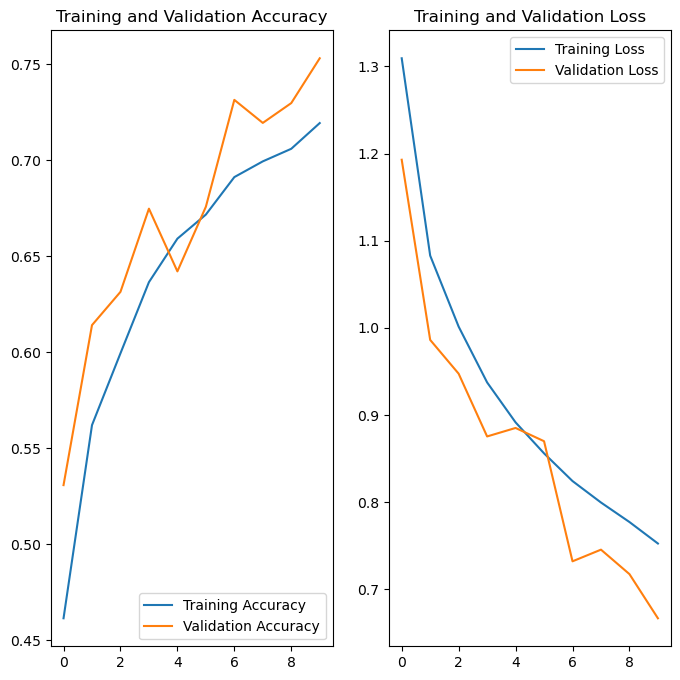

In [106]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

La precisión en entrenamiento en validación aumentan de manera constante a lo largo de las épocas.

La precisión de validación es incluso superior a la de entrenamiento en algunos puntos, lo que indica que el modelo generaliza bien (no hay señales de sobreajuste).

La precisión final se encuentra entre 0.70 y 0.77, lo cual es una mejora significativa en comparación con el primer modelo basado solo en capas densas.

Tanto la pérdida de entrenamiento como la pérdida de validación disminuyen, lo cual indica que el modelo está aprendiendo adecuadamente.
La pérdida de validación tiene algunas pequeñas variaciones/picos (especialmente entre las épocas 2 y 5), pero finalmente sigue bajando.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


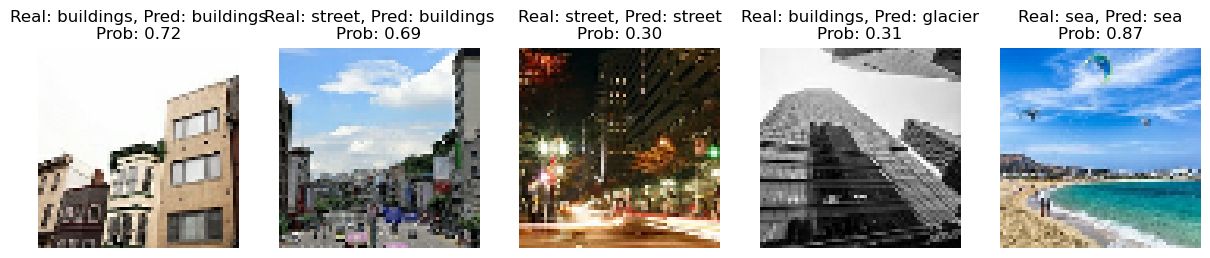

In [107]:
i = 0
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for images, labels in val_ds.take(5):  # Tomamos un batch del conjunto de validación
    Y_pred = model_2.predict(images)

    idx = np.random.randint(0, images.shape[0])  # Selecciona un índice aleatorio del batch
    x_test = images[idx].numpy()  # Imagen de prueba

    # Asegurar que la imagen esté en el rango [0, 1]
    if x_test.max() > 1.0:
        x_test = np.clip(x_test / 255.0, 0, 1)

    y_test_label = np.argmax(labels[idx].numpy())  # Clase real
    y_pred = np.argmax(Y_pred[idx])  # Clase predicha
    y_pred_prob = np.max(Y_pred[idx])  # Probabilidad de la clase predicha

    # Mostrar la imagen
    axs[i].imshow(x_test)  # Mostrar la imagen RGB
    axs[i].axis('off')

    # Mostrar el título con la clase real, la predicha y la probabilidad
    axs[i].set_title(f"Real: {class_names[y_test_label]}, Pred: {class_names[y_pred]}\nProb: {y_pred_prob:.2f}")

    i += 1  # Incrementar el índice

plt.show()


Adjuntamos la imagen de una de las ejecuciones

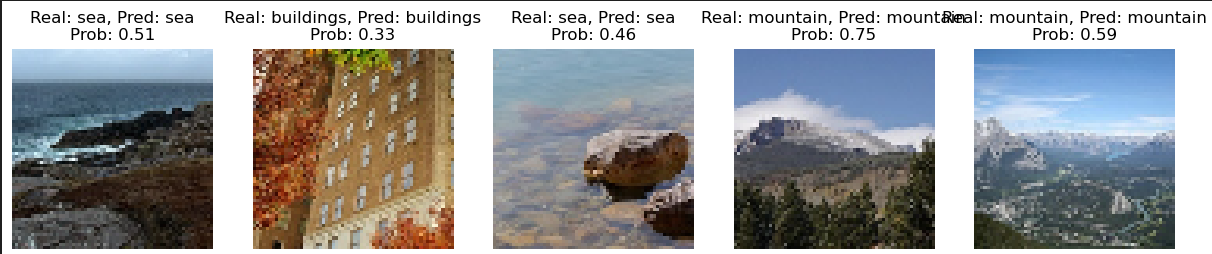

Donde podemos ver que clasifica bien todas las imagenes, este no siempre fue asi, pero por lo general predice correctamente alrededor de tres en cada lote.

In [108]:
results_model(time_3, time_4, "Modelo con capas convolucionales y densas", model_2, history_2)

# Modelo que incluye bloques residuales identidad (ResNet)

In [109]:
# Bloque residual identidad
def residual_block(x, filters):
    shortcut = x  # El puente (shortcut)
    
    # ver 
    # Si el número de filtros no coincide, aplicamos una convolución 1x1 al shortcut
    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(x)

    # Primera capa convolucional + BatchNorm + ReLU
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Segunda capa convolucional + BatchNorm
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Suma de la entrada original (shortcut) con la salida de las convoluciones
    x = Add()([x, shortcut])
    output = ReLU()(x)

    return output

In [110]:
# Modelo tipo ResNet usando bloques residuales
def resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)
    
    # Primera capa convolucional + MaxPooling
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Bloques residuales
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # Otro bloque con más filtros
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    # Global Average Pooling + Fully Connected
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Construcción del modelo
    model = tf.keras.Model(inputs, outputs)
    return model

In [111]:
model_3 = resnet_model((64, 64, 3), num_classes) 


In [112]:
model_3.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 64, 64, 3) │          0 │ input_layer_8[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │      9,472 │ rescaling_7[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 16, 16,    │     36,928 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 16, 16,    │          0 │ add_4[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │     36,928 │ re_lu_9[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │     36,928 │ re_lu_10[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 719,750 (2.75 MB)

 Trainable params: 718,214 (2.74 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [113]:
model_3.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Definimos el callback de early stopping
# early_stopping = EarlyStopping(
#     monitor='val_accuracy',    
#     patience=3,             # Espera 3 épocas sin mejora antes de detener
#     restore_best_weights=True  # Restaura los mejores pesos
# )

# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
time_5 = time.time()
history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # callbacks=[early_stopping]
)
time_6 = time.time()

Epoch 1/10


220/220 ━━━━━━━━━━━━━━━━━━━━ 107s 423ms/step - accuracy: 0.5907 - loss: 1.0381 - val_accuracy: 0.3857 - val_loss: 1.9209
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 98s 444ms/step - accuracy: 0.7489 - loss: 0.6846 - val_accuracy: 0.3157 - val_loss: 4.2818
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 412ms/step - accuracy: 0.7862 - loss: 0.5924 - val_accuracy: 0.5917 - val_loss: 1.2252
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 108s 490ms/step - accuracy: 0.8118 - loss: 0.5327 - val_accuracy: 0.6477 - val_loss: 1.0304
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 90s 407ms/step - accuracy: 0.8299 - loss: 0.4860 - val_accuracy: 0.4610 - val_loss: 3.1249
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 103s 467ms/step - accuracy: 0.8366 - loss: 0.4556 - val_accuracy: 0.3263 - val_loss: 4.6126
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 96s 435ms/step - accuracy: 0.8426 - loss: 0.4381 - val_accuracy: 0.4753 - val_loss: 1.7889
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 413ms/step - accuracy: 0.8522 - loss: 0.4161 - 

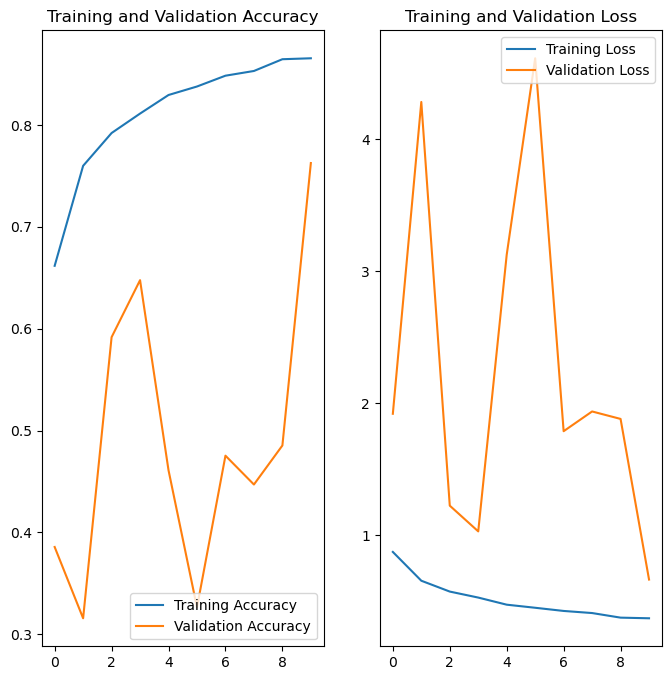

In [114]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

En primer lugar este modelo no tenia el early stopping decidimos agregarselo para detener el entrenamiento tan pronto como la pérdida de validación deje de mejorar, evitando que el modelo sobreajuste y estabilizando el rendimiento de validación. Pero a pesar de esto, seguia enrtenando con 10 épocas, por lo que decidimos comentarlo.

Con respecto a los gráficos obtenidos se puede observar que la precisión del entrenamiento es consistentemente alta y mejora a lo largo de las épocas. Mientras que la precisión en validación es muy inestable, con picos y caídas significativas. Esto indica que el modelo podría estar sobreajustándose a los datos de entrenamiento y no generaliza bien en el conjunto de validación. De forma similar podemos ver este compartamiento en la gráfica de loss.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


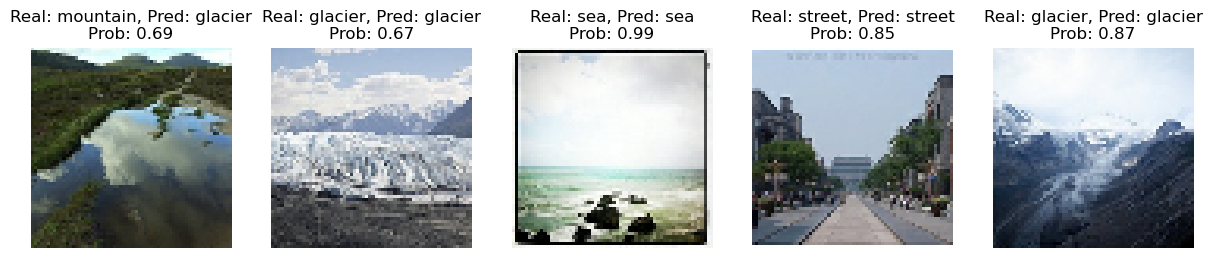

In [115]:
i = 0
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for images, labels in val_ds.take(5):  # Tomamos un batch del conjunto de validación
    Y_pred = model_3.predict(images)

    idx = np.random.randint(0, images.shape[0])  # Selecciona un índice aleatorio del batch
    x_test = images[idx].numpy()  # Imagen de prueba

    # Asegurar que la imagen esté en el rango [0, 1]
    if x_test.max() > 1.0:
        x_test = np.clip(x_test / 255.0, 0, 1)

    y_test_label = np.argmax(labels[idx].numpy())  # Clase real
    y_pred = np.argmax(Y_pred[idx])  # Clase predicha
    y_pred_prob = np.max(Y_pred[idx])  # Probabilidad de la clase predicha

    # Mostrar la imagen
    axs[i].imshow(x_test)  # Mostrar la imagen RGB
    axs[i].axis('off')

    # Mostrar el título con la clase real, la predicha y la probabilidad
    axs[i].set_title(f"Real: {class_names[y_test_label]}, Pred: {class_names[y_pred]}\nProb: {y_pred_prob:.2f}")

    i += 1  # Incrementar el índice

plt.show()


Podemos observar que predice perfectamente las 5 imagenes, lo cual era de esperar por los valores obtenidos de precisión.

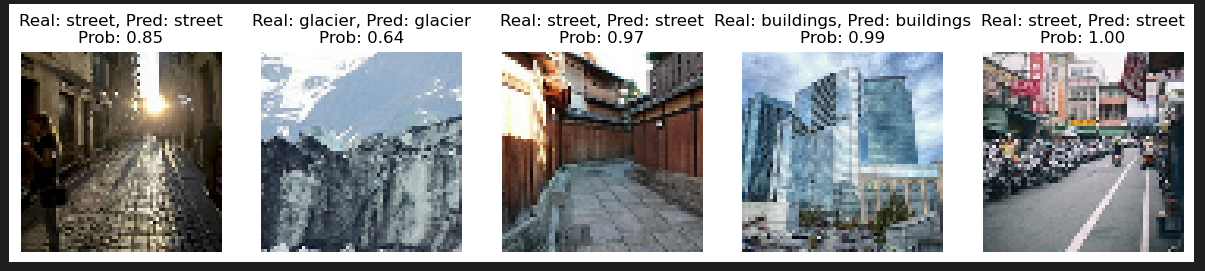

In [116]:
results_model(time_5, time_6, "ResNet", model_3, history_3)

# Modelo que utiliza como backbone alguna de las arquitecturas disponibles en TensorFlow 

Elegemis MobileNet. La elección fue al azar, la idea era probar algunos modelos y ver cual era mejor. Como con este modelo obtenemos buenos resultados y no tarde mucho tiempo en correrse, decidimos dejarlo como definitivo.

In [117]:
def mobilenet_model(input_shape, num_classes):
    # Cargamos MobileNet con pesos preentrenados de ImageNet, sin la capa superior (top).
    backbone = MobileNet(input_shape=input_shape, 
                         include_top=False,  # No usamos la cabeza de clasificación original
                         weights='imagenet')  # Pesos preentrenados en ImageNet

    # Congelamos las capas del backbone para que no se entrenen
    backbone.trainable = False  

    # Definimos la entrada del modelo
    inputs = Input(shape=input_shape)
    x = Rescaling(1./255)(inputs)

    # Pasamos la entrada a través del backbone MobileNet
    x = backbone(x, training=False)  # Configuramos en modo inferencia (sin dropout)

    # Agregamos Global Average Pooling para reducir dimensionalidad
    x = GlobalAveragePooling2D()(x)

    # Agregamos una capa densa para la clasificación
    x = Dense(256, activation='relu')(x)

    # Capa de salida con 'num_classes' neuronas para la predicción de las categorías
    outputs = Dense(num_classes, activation='softmax')(x)

    # Definimos el modelo completo
    model = Model(inputs, outputs)

    return model

In [118]:
model_4 = mobilenet_model((64, 64, 3), num_classes)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_26776\2479002422.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNet(input_shape=input_shape,


In [119]:
# Resumen del modelo
model_4.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 2, 2, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,492,806 (13.32 MB)

 Trainable params: 263,942 (1.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [120]:
model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Número de épocas de entrenamiento
EPOCHS = 5
# Entrena el modelo
time_7 = time.time()
history_4 = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True
)
time_8 = time.time()

Epoch 1/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - accuracy: 0.7422 - loss: 0.7366 - val_accuracy: 0.8200 - val_loss: 0.4903
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 28s 126ms/step - accuracy: 0.8696 - loss: 0.3564 - val_accuracy: 0.8230 - val_loss: 0.4984
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.9080 - loss: 0.2624 - val_accuracy: 0.8160 - val_loss: 0.4895
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.9381 - loss: 0.1871 - val_accuracy: 0.8193 - val_loss: 0.5318
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - accuracy: 0.9633 - loss: 0.1306 - val_accuracy: 0.8180 - val_loss: 0.6019


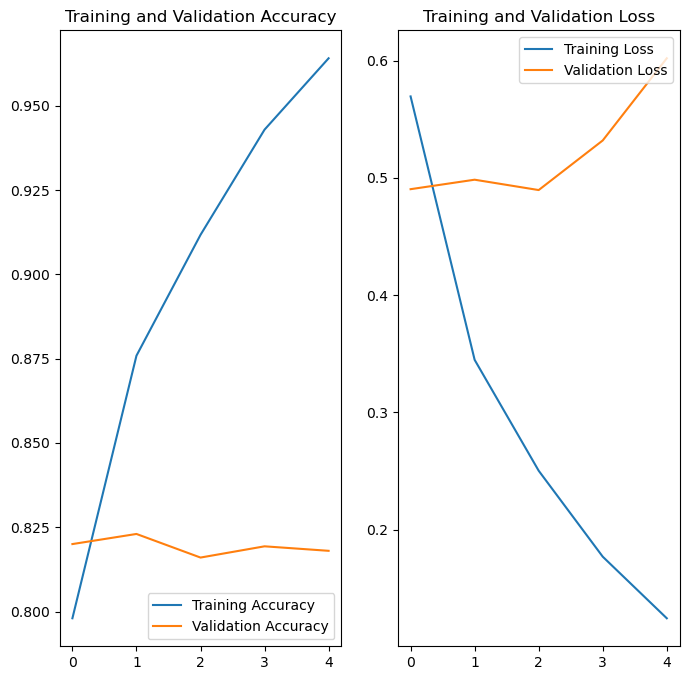

In [121]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']

loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

A partir del gráfico y de los valores de los parámetros obtenidos en en cada época podemos obervar algunas cosas:
* La precisión del entrenamiento aumenta de forma constante hasta acercarse al 97%, lo que indica que el modelo está aprendiendo bien los patrones del conjunto de entrenamiento. Mientras que la precisión en validación se mantiene prácticamente constante (alrededor de 82-83%) a lo largo de las épocas, lo que sugiere que el modelo tiene problemas para mejorar su rendimiento en datos de validación.
* En cuanto a la pérdida en entrenamiento disminuye de manera significativa, lo que es esperado cuando el modelo aprende bien del conjunto de entrenamiento. La pérdida en validación se mantiene constante e incluso aumenta al final.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


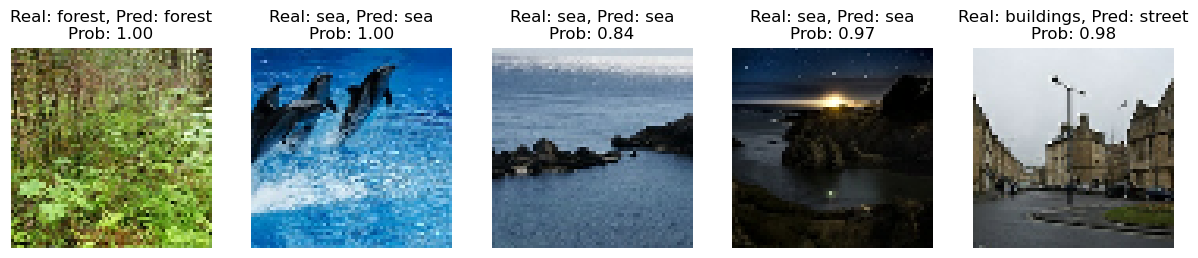

In [122]:
i = 0
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for images, labels in val_ds.take(5):  # Tomamos un batch del conjunto de validación
    Y_pred = model_4.predict(images)

    idx = np.random.randint(0, images.shape[0])  # Selecciona un índice aleatorio del batch
    x_test = images[idx].numpy()  # Imagen de prueba

    # Asegurar que la imagen esté en el rango [0, 1]
    if x_test.max() > 1.0:
        x_test = np.clip(x_test / 255.0, 0, 1)

    y_test_label = np.argmax(labels[idx].numpy())  # Clase real
    y_pred = np.argmax(Y_pred[idx])  # Clase predicha
    y_pred_prob = np.max(Y_pred[idx])  # Probabilidad de la clase predicha

    # Mostrar la imagen
    axs[i].imshow(x_test)  # Mostrar la imagen RGB
    axs[i].axis('off')

    # Mostrar el título con la clase real, la predicha y la probabilidad
    axs[i].set_title(f"Real: {class_names[y_test_label]}, Pred: {class_names[y_pred]}\nProb: {y_pred_prob:.2f}")

    i += 1  # Incrementar el índice

plt.show()


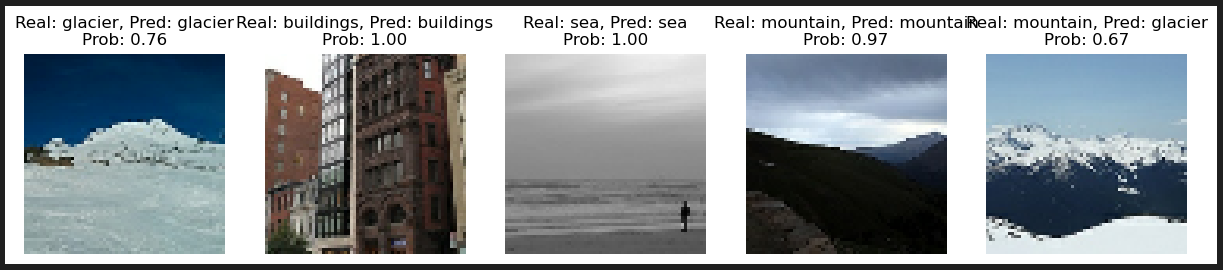

Podemos observar que el modelo predice perfectamente las 5 imagenes que les fueron pasadas para probarlo. Vale aclarar que adjuntamos una imagen, ya que en cada ejección del código pueden variar

# Conclusiones 

En la tabla que se encuentra a contianución se muestran métricas, tiempo de ejeccución y cantidad de parámetros para cada uno de los modelos utilizados.

In [124]:
results_model(time_7, time_8, "Mobile Net", model_4, history_4)
# Crear DataFrame con los resultados
df_results = pd.DataFrame(results)

# Mostrar la tabla en formato tabular
print(df_results)


                                      Modelo  Train Accuracy  Val Accuracy  \
0                    Modelo con capas densas            0.58          0.52   
1  Modelo con capas convolucionales y densas            0.72          0.75   
2                                     ResNet            0.87          0.76   
3                                 Mobile Net            0.96          0.82   

   Total Parámetros  Parámetros Entrenables  Parámetros No Entrenables  \
0            786886                  786886                          0   
1             38358                   38358                          0   
2            719750                  718214                       1536   
3           3492806                  263942                    3228864   

   Tiempo Entrenamiento (min)  
0                        1.24  
1                        3.01  
2                       16.01  
3                        2.45  


Como era de esperar el modelo que solo tiene **capas densas** tiene un rendimiento bajo y no logra buenos resultados. Esto sucede a que es un modelo simple, tiene un total de 789.886 parámetros y tarda en ejecutarse 1,17 minutos.

Pero podemos observar como estos valores mejoran considerablemente al agregar capas convolucionles, la precisión tanto de entrenamiento como de valiación aumentan en 0,20 en comparación con el primer modelo implementado.

Además en este modelo que contiene **capas convoluciones y densas**, la precisión en validación es incluso superior a la de entrenamiento, lo que sugiere una buena capacidad de generalización. Esto podría deberse a que las capas convolucionales ayudan a capturar patrones espaciales en los datos.

Sin embargo, este segundo modelo tiene un cantidad menor de parámetros que el primero. Tiene 38.358 parámetros y tarde en ejecutarse 3,22 minutos aproximadante. Esto nos dice que a pesar de ser pequeño, ofrece un rendimiento notablemente mejor que el modelo con solo capas densas, lo que destaca la eficiencia de las capas convolucionales. 


En cuanto a **ResNet**, si biene tiene un muy buen desempeño en entrenamiento pero cae en validación, lo cual nos podría indicar que hay un poco de sobreajuste.

Además ResNet tiene un total de parámetros de 719.750 ( de los cuales 1.536 son no entrenables) y tiene el tiempo de entrenamiento más largo: 15.7 min. Esto hace que este modelo sea más complejo y el más tiempo de entrenamiento toma.

En el caso de **MobileNet**, este modelo tiene la mayor precisión tanto en entrenamiento como en validación. La alta precisión en validación indica que MobileNet logra un buen balance entre capacidad y generalización.
En cuanto a parámetros cuenta con un total de 3,492,806  (1.536 no entrenables), es el que más cantidad de parametross tiene, sin embargo el tiempo de ejecución no es alto, ya que es de 2,7 minutos. Este es el único modelo que entrenamos con 5 épocas, mientras que todos los demas los entrenamos con 10.

Consideramos que **MobileNet** es el mejor modelo ya que frece el mejor balance entre precisión y generalización. Sin embargo, si necesitamos más velocidad o menos recursos, también es un buen candidato el modelo con capas convolucionales y densas.

